# Financial News Classifier - DistilBERT Fine-tuning

This notebook trains a DistilBERT model to classify whether a news article is financial or not.

**Purpose**: Act as a gatekeeper before sentiment analysis to filter only financial news.

**Model**: DistilBERT (distilbert-base-uncased)

**Task**: Binary Classification (Financial vs Non-Financial)

## 1. Setup and Installations

## 2. Import Libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Transformers and PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)

# Sklearn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

d:\Documents\ECE\2025\PFE\FinsightAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


Using device: cpu


## 3. Configuration

In [2]:
# Model configuration
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 256,
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 4,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'output_dir': './financial_news_classifier',
    'save_steps': 500,
    'logging_steps': 100
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Label mapping
LABEL_MAP = {
    'non_financial': 0,
    'financial': 1
}

ID2LABEL = {0: 'Non-Financial', 1: 'Financial'}
LABEL2ID = {'Non-Financial': 0, 'Financial': 1}

print("Configuration:")
print(json.dumps(CONFIG, indent=2))

Configuration:
{
  "model_name": "distilbert-base-uncased",
  "max_length": 256,
  "batch_size": 16,
  "learning_rate": 2e-05,
  "epochs": 4,
  "warmup_steps": 500,
  "weight_decay": 0.01,
  "train_split": 0.8,
  "val_split": 0.1,
  "test_split": 0.1,
  "output_dir": "./financial_news_classifier",
  "save_steps": 500,
  "logging_steps": 100
}


## 4. Data Preparation

### Option 1: Using Public Datasets

We'll combine multiple datasets:
- **Financial News**: Financial PhraseBank, Reuters Financial News
- **Non-Financial News**: AG News, BBC News, general news datasets

In [3]:
def load_ag_news_data():
    """
    Load AG News dataset (train.csv and test.csv)
    Class Index 3 = Business/Financial news
    Class Index 1, 2, 4 = Non-financial (World, Sports, Sci/Tech)
    """
    # Load train and test files
    train_path = './data/News/train.csv'
    test_path = './data/News/test.csv'
    
    train_ag = pd.read_csv(train_path)
    test_ag = pd.read_csv(test_path)
    
    # Combine train and test
    ag_news = pd.concat([train_ag, test_ag], ignore_index=True)
    
    # Create text column by combining Title and Description
    ag_news['text'] = ag_news['Title'] + '. ' + ag_news['Description']
    
    # Map Class Index to binary labels
    # Class 3 = Business/Financial = 1
    # Class 1, 2, 4 = Non-Financial = 0
    ag_news['label'] = ag_news['Class Index'].apply(lambda x: 1 if x == 3 else 0)
    ag_news['label_name'] = ag_news['label'].apply(lambda x: 'Financial' if x == 1 else 'Non-Financial')
    
    # Select relevant columns
    ag_news = ag_news[['text', 'label', 'label_name']]
    
    print(f"AG News dataset loaded: {len(ag_news)} samples")
    print(f"Financial: {len(ag_news[ag_news['label'] == 1])}")
    print(f"Non-Financial: {len(ag_news[ag_news['label'] == 0])}")
    
    return ag_news


def load_bbc_news_data():
    """
    Load BBC News dataset and split it
    Will need to manually label or infer which categories are financial
    """
    bbc_path = './data/News/bbc-news-data.csv'
    
    try:
        bbc_news = pd.read_csv(bbc_path)
        
        # Check if there's a category column to help identify financial news
        print(f"\nBBC News columns: {bbc_news.columns.tolist()}")
        print(f"BBC News shape: {bbc_news.shape}")
        
        # If BBC has category column, map business/financial categories to label 1
        # Adjust this based on actual BBC data structure
        if 'category' in bbc_news.columns:
            financial_categories = ['business', 'finance', 'economy', 'stock', 'market']
            bbc_news['label'] = bbc_news['category'].str.lower().apply(
                lambda x: 1 if any(cat in str(x).lower() for cat in financial_categories) else 0
            )
        else:
            # If no category, we'll need to create text column and label manually
            # For now, we'll skip BBC or label all as non-financial
            print("Warning: BBC News doesn't have category column. Skipping for now.")
            return None
        
        # Create text column (adjust based on actual column names)
        if 'title' in bbc_news.columns and 'description' in bbc_news.columns:
            bbc_news['text'] = bbc_news['title'] + '. ' + bbc_news['description']
        elif 'text' not in bbc_news.columns:
            print("Warning: Cannot find text columns in BBC News. Skipping.")
            return None
        
        bbc_news['label_name'] = bbc_news['label'].apply(lambda x: 'Financial' if x == 1 else 'Non-Financial')
        bbc_news = bbc_news[['text', 'label', 'label_name']]
        
        print(f"BBC News dataset loaded: {len(bbc_news)} samples")
        print(f"Financial: {len(bbc_news[bbc_news['label'] == 1])}")
        print(f"Non-Financial: {len(bbc_news[bbc_news['label'] == 0])}")
        
        return bbc_news
    
    except Exception as e:
        print(f"Error loading BBC News: {e}")
        return None


# Load datasets
print("="*60)
print("Loading Datasets")
print("="*60)

# Load AG News
ag_news_df = load_ag_news_data()

# Load BBC News (optional)
bbc_news_df = load_bbc_news_data()

# Combine datasets
if bbc_news_df is not None:
    df = pd.concat([ag_news_df, bbc_news_df], ignore_index=True)
    print(f"\n✅ Combined dataset: {len(df)} samples")
else:
    df = ag_news_df
    print(f"\n✅ Using AG News only: {len(df)} samples")

# Shuffle the dataset
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Display statistics
print("\n" + "="*60)
print("Dataset Statistics")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"\nLabel distribution:")
print(df['label_name'].value_counts())
print(f"\nLabel percentages:")
print(df['label_name'].value_counts(normalize=True) * 100)
print(f"\nSample data:")
print(df.head(10))


Loading Datasets
AG News dataset loaded: 127600 samples
Financial: 31900
Non-Financial: 95700
Error loading BBC News: Error tokenizing data. C error: Expected 30 fields in line 7, saw 34


✅ Using AG News only: 127600 samples

Dataset Statistics
Total samples: 127600

Label distribution:
label_name
Non-Financial    95700
Financial        31900
Name: count, dtype: int64

Label percentages:
label_name
Non-Financial    75.0
Financial        25.0
Name: proportion, dtype: float64

Sample data:
                                                text  label     label_name
0  No. 3 Georgia Tech 79, Arkansas-Little Rock 54...      0  Non-Financial
1  Carter #39;s  #39;got nothing to say #39; afte...      0  Non-Financial
2  Adobe offers standard for raw photo formats. T...      0  Non-Financial
3  Antibiotic hope for Parkinson's. \An antibioti...      0  Non-Financial
4  Exit Blog, Enter Legg. A high-profile departur...      1      Financial
5  IOC opens investigation into allegations again...    

### Load Real Datasets (Optional)

Uncomment and modify the following cell to load your actual datasets:

In [4]:
# Optional: Inspect the actual data structure
print("Checking data structure...")
print(f"\nFirst few samples from Financial news:")
print(df[df['label'] == 1].head(3)['text'].values)
print(f"\nFirst few samples from Non-Financial news:")
print(df[df['label'] == 0].head(3)['text'].values)

# Check for any missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Remove any rows with missing text
if df['text'].isnull().sum() > 0:
    print(f"\nRemoving {df['text'].isnull().sum()} rows with missing text...")
    df = df.dropna(subset=['text']).reset_index(drop=True)
    print(f"Final dataset size: {len(df)}")


Checking data structure...

First few samples from Financial news:
['Exit Blog, Enter Legg. A high-profile departure and a higher-profile purchase mean nothing ever gets boring at Google.'
 'Holiday shoppers hospitalized after spray released in toy store. _ At least three people were hospitalized and others suffered irritated eyes when someone released pepper spray at Toys R Us #39; flagship store during the busy holiday shopping weekend, fire and police spokesmen said.'
 'Bank holds interest rates steady at 4.75. THE Bank of England left its key interest rate at 4.75 per cent yesterday, a decision that was widely expected, after a raft of data that showed the economy was cooling down.']

First few samples from Non-Financial news:
['No. 3 Georgia Tech 79, Arkansas-Little Rock 54. Georgia Tech was in no mood to celebrate this victory, not after a sickening injury to one of its most promising players. BJ Elder scored 23 points and the third-ranked Yellow Jackets started '
 'Carter #39;s 

In [ ]:
# Option 2: Undersampling (if you prefer - NOT RECOMMENDED for this case)
# Uncomment to use undersampling instead of class weights

# from sklearn.utils import resample

# # Separate classes
# df_financial = df[df['label'] == 1]
# df_non_financial = df[df['label'] == 0]

# # Undersample majority class
# df_non_financial_downsampled = resample(
#     df_non_financial,
#     replace=False,
#     n_samples=len(df_financial),
#     random_state=SEED
# )

# # Combine
# df = pd.concat([df_financial, df_non_financial_downsampled])
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# print(f"After undersampling: {len(df)} samples")
# print(df['label_name'].value_counts())

In [ ]:
# Option 1: Calculate class weights (RECOMMENDED)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights (to handle imbalance):")
print(f"  Non-Financial (class 0): {class_weights_dict[0]:.4f}")
print(f"  Financial (class 1): {class_weights_dict[1]:.4f}")
print(f"\n✅ Financial class will be weighted {class_weights_dict[1]/class_weights_dict[0]:.2f}x more during training")

# Store in config for later use
CONFIG['use_class_weights'] = True
CONFIG['class_weights'] = class_weights_dict

### Handle Class Imbalance

The dataset has a 3:1 ratio (75% Non-Financial, 25% Financial). We have several options:

1. **Class Weights (Recommended)**: Weight the loss function to penalize errors on minority class more
2. **Undersampling**: Reduce Non-Financial samples to match Financial (lose 60K+ samples ❌)
3. **Oversampling**: Duplicate Financial samples to match Non-Financial (risk overfitting)
4. **Keep as-is**: 3:1 ratio is actually manageable

We'll use **Class Weights** as it's the best approach for this case.

### Data Visualization

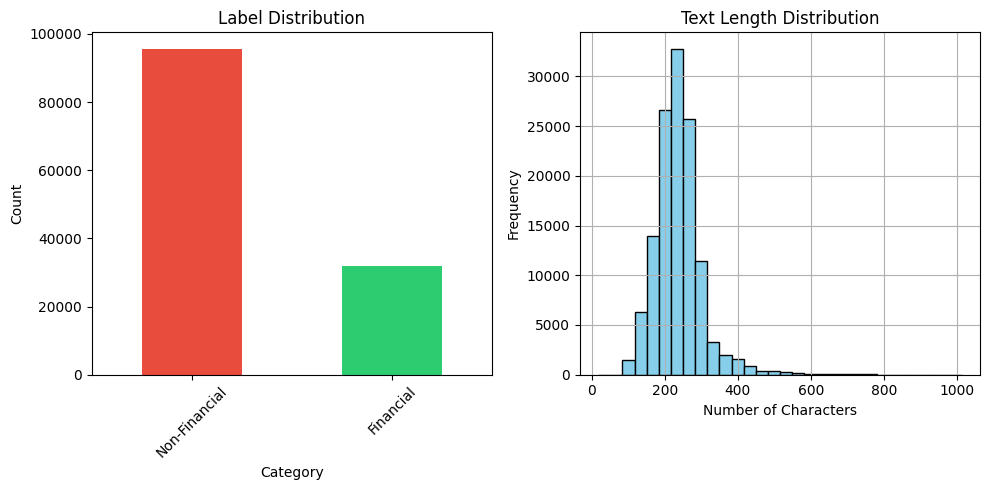

Text length statistics:
count    127600.000000
mean        237.390361
std          66.457496
min          18.000000
25%         197.000000
50%         233.000000
75%         267.000000
max        1013.000000
Name: text, dtype: float64


In [5]:
# Visualize label distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['label_name'].value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'])
plt.title('Label Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['text'].str.len().hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Text length statistics:")
print(df['text'].str.len().describe())

## 5. Data Splitting

In [ ]:
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(
    df,
    test_size=(1 - CONFIG['train_split']),
    random_state=SEED,
    stratify=df['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=CONFIG['test_split'] / (CONFIG['val_split'] + CONFIG['test_split']),
    random_state=SEED,
    stratify=temp_df['label']
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print(f"\nTrain label distribution:")
print(train_df['label_name'].value_counts())
print(f"\nValidation label distribution:")
print(val_df['label_name'].value_counts())
print(f"\nTest label distribution:")
print(test_df['label_name'].value_counts())

## 6. Custom Dataset Class

In [ ]:
class FinancialNewsDataset(Dataset):
    """Custom Dataset for Financial News Classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## 7. Initialize Tokenizer and Model

In [ ]:
# Load tokenizer
print("Loading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(CONFIG['model_name'])

# Load model
print("Loading model...")
model = DistilBertForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=2,
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

model = model.to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nNumber of parameters: {sum(p.numel() for p in model.parameters()):,}")

## 8. Create DataLoaders

In [ ]:
# Create datasets
train_dataset = FinancialNewsDataset(
    texts=train_df['text'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

val_dataset = FinancialNewsDataset(
    texts=val_df['text'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

test_dataset = FinancialNewsDataset(
    texts=test_df['text'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

## 9. Training Setup

In [ ]:
# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
total_steps = len(train_loader) * CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CONFIG['warmup_steps'],
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {CONFIG['warmup_steps']}")

## 10. Training and Evaluation Functions

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device, epoch, class_weights=None):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    # Setup class weights if provided
    if class_weights is not None:
        weight_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float).to(device)
        loss_fn = torch.nn.CrossEntropyLoss(weight=weight_tensor)
    else:
        loss_fn = None
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        if loss_fn is not None:
            # Use custom loss with class weights
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            loss = loss_fn(logits, labels)
        else:
            # Use default loss
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
        
        # Track metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy


def evaluate(model, dataloader, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

## 11. Training Loop

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': []
}

best_val_f1 = 0
best_model_path = os.path.join(CONFIG['output_dir'], 'best_model')

# Get class weights if enabled
class_weights = CONFIG.get('class_weights', None) if CONFIG.get('use_class_weights', False) else None

if class_weights:
    print("\n⚖️  Using class weights to handle imbalance")
    print(f"   Non-Financial: {class_weights[0]:.4f}")
    print(f"   Financial: {class_weights[1]:.4f}")

print("\n" + "="*50)
print("Starting Training")
print("="*50 + "\n")

for epoch in range(1, CONFIG['epochs'] + 1):
    print(f"\nEpoch {epoch}/{CONFIG['epochs']}")
    print("-" * 50)
    
    # Train with class weights
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, device, epoch, class_weights
    )
    
    # Validate
    val_metrics = evaluate(model, val_loader, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_accuracy'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
    print(f"Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    
    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        print(f"\n🎯 New best model! F1: {best_val_f1:.4f}")
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Model saved to {best_model_path}")

print("\n" + "="*50)
print("Training Complete!")
print("="*50)

## 12. Training Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='s')
axes[1].plot(history['val_f1'], label='Val F1', marker='^')
axes[1].set_title('Training and Validation Metrics')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

## 13. Load Best Model and Evaluate on Test Set

In [ ]:
# Load best model
print("Loading best model...")
best_model = DistilBertForSequenceClassification.from_pretrained(best_model_path)
best_model = best_model.to(device)

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate(best_model, test_loader, device)

print("\n" + "="*50)
print("Test Set Results")
print("="*50)
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1']:.4f}")

## 14. Detailed Classification Report

In [ ]:
# Classification report
print("\nClassification Report:")
print("="*50)
print(classification_report(
    test_metrics['true_labels'],
    test_metrics['predictions'],
    target_names=['Non-Financial', 'Financial']
))

## 15. Confusion Matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_metrics['true_labels'], test_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-Financial', 'Financial'],
    yticklabels=['Non-Financial', 'Financial']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(CONFIG['output_dir'], 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

## 16. Inference Function

In [ ]:
def predict_financial_news(text, model, tokenizer, device, max_length=256):
    """
    Predict if a news article is financial or not.
    
    Args:
        text (str): News text to classify
        model: Trained model
        tokenizer: Tokenizer
        device: Device to run on
        max_length: Maximum sequence length
    
    Returns:
        dict: Prediction results with label, confidence, and probabilities
    """
    model.eval()
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()
    
    return {
        'text': text,
        'is_financial': bool(prediction),
        'label': 'Financial' if prediction == 1 else 'Non-Financial',
        'confidence': confidence,
        'probabilities': {
            'non_financial': probabilities[0][0].item(),
            'financial': probabilities[0][1].item()
        }
    }

print("Inference function defined.")

## 17. Test Inference

In [ ]:
# Test examples
test_examples = [
    "Apple's stock price surged 5% after beating quarterly earnings expectations.",
    "The Federal Reserve announced a 0.25% interest rate increase to combat inflation.",
    "A new species of butterfly was discovered in the Amazon rainforest.",
    "The local football team won the championship in a thrilling overtime match.",
    "Tesla's market cap exceeded $1 trillion after strong vehicle delivery numbers.",
    "Scientists published a breakthrough study on climate change mitigation."
]

print("\n" + "="*80)
print("Testing Inference on Sample Texts")
print("="*80 + "\n")

for text in test_examples:
    result = predict_financial_news(text, best_model, tokenizer, device)
    
    print(f"Text: {text[:80]}..." if len(text) > 80 else f"Text: {text}")
    print(f"Prediction: {result['label']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilities: Non-Financial={result['probabilities']['non_financial']:.2%}, Financial={result['probabilities']['financial']:.2%}")
    print("-" * 80 + "\n")

## 18. Save Configuration and Results

In [ ]:
# Save training configuration and results
results = {
    'config': CONFIG,
    'best_val_f1': best_val_f1,
    'test_metrics': {
        'loss': test_metrics['loss'],
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1']
    },
    'history': history,
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
}

results_path = os.path.join(CONFIG['output_dir'], 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {results_path}")

## 19. Export Model for Production Use

In [ ]:
# Create a production-ready wrapper class
class FinancialNewsClassifier:
    """Production-ready Financial News Classifier"""
    
    def __init__(self, model_path, device='cpu'):
        self.device = device
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_path)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path)
        self.model = self.model.to(device)
        self.model.eval()
    
    def predict(self, text, threshold=0.5):
        """Predict if text is financial news"""
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs.logits, dim=1)
            financial_prob = probabilities[0][1].item()
        
        return {
            'is_financial': financial_prob >= threshold,
            'confidence': financial_prob,
            'label': 'Financial' if financial_prob >= threshold else 'Non-Financial'
        }
    
    def batch_predict(self, texts, threshold=0.5):
        """Predict for multiple texts"""
        return [self.predict(text, threshold) for text in texts]

# Save the wrapper class
wrapper_code = '''
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

class FinancialNewsClassifier:
    """Production-ready Financial News Classifier"""
    
    def __init__(self, model_path, device='cpu'):
        self.device = device
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_path)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path)
        self.model = self.model.to(device)
        self.model.eval()
    
    def predict(self, text, threshold=0.5):
        """Predict if text is financial news"""
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs.logits, dim=1)
            financial_prob = probabilities[0][1].item()
        
        return {
            'is_financial': financial_prob >= threshold,
            'confidence': financial_prob,
            'label': 'Financial' if financial_prob >= threshold else 'Non-Financial'
        }
    
    def batch_predict(self, texts, threshold=0.5):
        """Predict for multiple texts"""
        return [self.predict(text, threshold) for text in texts]

# Usage example:
# classifier = FinancialNewsClassifier('./financial_news_classifier/best_model')
# result = classifier.predict("Apple stock rises on earnings beat")
# print(result)
'''

with open(os.path.join(CONFIG['output_dir'], 'financial_news_classifier.py'), 'w') as f:
    f.write(wrapper_code)

print(f"\n✅ Production wrapper saved to {CONFIG['output_dir']}/financial_news_classifier.py")

## 20. Integration Instructions

### How to Use This Model in Your Pipeline

```python
# 1. Import the classifier
from financial_news_classifier import FinancialNewsClassifier

# 2. Load the model
classifier = FinancialNewsClassifier(
    model_path='./financial_news_classifier/best_model',
    device='cuda'  # or 'cpu'
)

# 3. Classify news before sentiment analysis
news_text = "Apple reports record earnings for Q4 2025"
result = classifier.predict(news_text, threshold=0.7)

if result['is_financial']:
    # Pass to FinBERT for sentiment analysis
    sentiment = finbert_analyzer.analyze(news_text)
    print(f"Financial news detected with {result['confidence']:.2%} confidence")
    print(f"Sentiment: {sentiment}")
else:
    print(f"Non-financial news - skipping sentiment analysis")
```

### Pipeline Integration

```python
# Modify your pipeline to include the gatekeeper
def process_news_pipeline(news_articles):
    # Step 1: Filter financial news
    financial_classifier = FinancialNewsClassifier(model_path)
    
    filtered_articles = []
    for article in news_articles:
        result = financial_classifier.predict(article['text'])
        
        if result['is_financial']:
            article['financial_confidence'] = result['confidence']
            filtered_articles.append(article)
    
    # Step 2: Apply FinBERT sentiment analysis
    for article in filtered_articles:
        article['sentiment'] = finbert_analyzer.analyze(article['text'])
    
    return filtered_articles
```

## Summary

This notebook has:

1. ✅ Fine-tuned a DistilBERT model for binary classification (Financial vs Non-Financial)
2. ✅ Created training and evaluation pipelines
3. ✅ Visualized training progress and model performance
4. ✅ Provided inference functions for production use
5. ✅ Saved the best model and configuration
6. ✅ Created a production-ready wrapper class

### Next Steps:

1. **Collect more data**: Use real financial and non-financial news datasets
2. **Fine-tune hyperparameters**: Experiment with learning rate, batch size, epochs
3. **Test with real data**: Validate on your actual news pipeline
4. **Monitor performance**: Track precision/recall in production
5. **Iterate**: Retrain with misclassified examples

### Recommended Datasets:

**Financial News:**
- Financial PhraseBank
- Reuters Financial News
- Bloomberg News
- Your historical financial news data

**Non-Financial News:**
- AG News
- BBC News
- 20 Newsgroups
- General news scraping